In [1]:
import numpy as np
import pandas as pd

In [2]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
df = pd.read_csv('merged_nyc_grid_data.csv')

In [3]:
def prepare_data(file_path, batch_size=64, use_log = True, select_features = 25):
    """
    Load the NYC data from a csv file, split into test and training set, and pass it into a dataloader for training
    """

    df = pd.read_csv(file_path)
    print('Dataset loaded')
    print('Dataset shape: ',df.shape)

    # Check for non-numeric columns
    print("DataFrame info:")
    print(df.info())

    # Check for NaN values
    print("\nNaN values per column:")
    print(df.isna().sum())

    # Check column dtypes
    print("\nColumn dtypes:")
    print(df.dtypes)

    # Split features and target
    df['bike_volume_log'] = np.log1p(df['bike_volume']) # NEW

    X = df.drop('bike_volume', axis=1)
    if use_log:
        y = df['bike_volume_log']
    else:
        y = df['bike_volume']

    # Feature selection to reduce multicollinearity
    if select_features > 0:
        selector = SelectKBest(f_regression, k=select_features)  # Select top 25 features
        X_selected = selector.fit_transform(X, y)
        selected_feature_indices = selector.get_support(indices=True)
        selected_feature_names = X.columns[selected_feature_indices]
        print("Selected features:", selected_feature_names.tolist())

        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        train_dataset = BikeDataset(X_train, y_train.values)
        test_dataset = BikeDataset(X_test, y_test.values)

    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_dataset = BikeDataset(X_train.values, y_train.values)
        test_dataset = BikeDataset(X_test.values, y_test.values)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    input_dim = X_train.shape[1]
    print('Input dim: ', input_dim)

    return train_loader, test_loader, input_dim

In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
import joblib  # For saving the sklearn model

In [7]:
def prepare_data_sklearn(file_path, use_log=True, select_features=25):
    """
    Modified data preparation for scikit-learn models
    Returns numpy arrays instead of DataLoaders
    """
    df = pd.read_csv(file_path)
    
    # Create log-transformed target if specified
    y = np.log1p(df['bike_volume']) if use_log else df['bike_volume']
    X = df.drop('bike_volume', axis=1)
    
    # Feature selection
    if select_features > 0:
        selector = SelectKBest(f_regression, k=select_features)
        X = selector.fit_transform(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, use_log

In [3]:
def train_linear_regression(X_train, X_test, y_train, y_test, use_log):
    """
    Train and evaluate scikit-learn Linear Regression model
    """
    # Create and train model
    lr_model = LinearRegression(fit_intercept=True)
    lr_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = lr_model.predict(X_train)
    y_pred_test = lr_model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'train': {
            'r2': r2_score(y_train, y_pred_train),
            'mae': mean_absolute_error(y_train, y_pred_train),
            'mse': mean_squared_error(y_train, y_pred_train)
        },
        'test': {
            'r2': r2_score(y_test, y_pred_test),
            'mae': mean_absolute_error(y_test, y_pred_test),
            'mse': mean_squared_error(y_test, y_pred_test)
        }
    }
    
    # If using log-transform, calculate metrics in original scale
    if use_log:
        y_train_orig = np.expm1(y_train)
        y_test_orig = np.expm1(y_test)
        y_pred_train_orig = np.expm1(y_pred_train)
        y_pred_test_orig = np.expm1(y_pred_test)
        
        metrics['train_original_scale'] = {
            'mae': mean_absolute_error(y_train_orig, y_pred_train_orig),
            'mse': mean_squared_error(y_train_orig, y_pred_train_orig)
        }
        metrics['test_original_scale'] = {
            'mae': mean_absolute_error(y_test_orig, y_pred_test_orig),
            'mse': mean_squared_error(y_test_orig, y_pred_test_orig)
        }
    
    return lr_model, metrics

In [4]:
def visualize_metrics(metrics, use_log=True):
    """Visualize comparison between train and test metrics"""
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Log-scale metrics
    if use_log:
        ax[0].bar(['Train', 'Test'], [metrics['train']['mae'], metrics['test']['mae']], color=['blue', 'orange'])
        ax[0].set_title('MAE (log scale)')
        ax[1].bar(['Train', 'Test'], [metrics['train']['r2'], metrics['test']['r2']], color=['blue', 'orange'])
        ax[1].set_title('R² Score (log scale)')
    
    # Original-scale metrics
    if 'train_original_scale' in metrics:
        fig2, ax2 = plt.subplots(1, 2, figsize=(15, 6))
        ax2[0].bar(['Train', 'Test'], 
                  [metrics['train_original_scale']['mae'], 
                   metrics['test_original_scale']['mae']], 
                  color=['blue', 'orange'])
        ax2[0].set_title('MAE (original scale)')
        ax2[1].bar(['Train', 'Test'], 
                  [metrics['train_original_scale']['mse'], 
                   metrics['test_original_scale']['mse']], 
                  color=['blue', 'orange'])
        ax2[1].set_title('MSE (original scale)')
        
    plt.tight_layout()
    plt.show()
    plt.savefig('linear_regression_metrics_comparison.png')
    print("Metrics visualized and saved as linear_regression_metrics_comparison.png")

In [5]:
file_path = 'merged_nyc_grid_data.csv'
use_log = True
select_features = 25

In [8]:
X_train, X_test, y_train, y_test, use_log = prepare_data_sklearn(
    file_path, use_log, select_features
)

In [9]:
# model, metrics = train_linear_regression(X_train, X_test, y_train, y_test, use_log)

In [10]:
lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# Calculate metrics
metrics = {
    'train': {
        'r2': r2_score(y_train, y_pred_train),
        'mae': mean_absolute_error(y_train, y_pred_train),
        'mse': mean_squared_error(y_train, y_pred_train)
    },
    'test': {
        'r2': r2_score(y_test, y_pred_test),
        'mae': mean_absolute_error(y_test, y_pred_test),
        'mse': mean_squared_error(y_test, y_pred_test)
    }
}

# If using log-transform, calculate metrics in original scale
if use_log:
    y_train_orig = np.expm1(y_train)
    y_test_orig = np.expm1(y_test)
    y_pred_train_orig = np.expm1(y_pred_train)
    y_pred_test_orig = np.expm1(y_pred_test)
    
    metrics['train_original_scale'] = {
        'mae': mean_absolute_error(y_train_orig, y_pred_train_orig),
        'mse': mean_squared_error(y_train_orig, y_pred_train_orig)
    }
    metrics['test_original_scale'] = {
        'mae': mean_absolute_error(y_test_orig, y_pred_test_orig),
        'mse': mean_squared_error(y_test_orig, y_pred_test_orig)
    }

In [11]:
print("\nLog-scale Metrics:")
print(f"Train R²: {metrics['train']['r2']:.4f}, Test R²: {metrics['test']['r2']:.4f}")
print(f"Train MAE: {metrics['train']['mae']:.4f}, Test MAE: {metrics['test']['mae']:.4f}")

if use_log:
    print("\nOriginal-scale Metrics:")
    print(f"Train MAE: {metrics['train_original_scale']['mae']:.2f}, Test MAE: {metrics['test_original_scale']['mae']:.2f}")
    print(f"Train MSE: {metrics['train_original_scale']['mse']:.2f}, Test MSE: {metrics['test_original_scale']['mse']:.2f}")


Log-scale Metrics:
Train R²: 0.6225, Test R²: 0.4150
Train MAE: 1.2969, Test MAE: 1.8122

Original-scale Metrics:
Train MAE: 43912.00, Test MAE: 57415.47
Train MSE: 6089121220.90, Test MSE: 14601626645.36


In [12]:
joblib.dump(lr_model, 'linear_regression_model.pkl')
print("\nModel saved to linear_regression_model.pkl")


Model saved to linear_regression_model.pkl


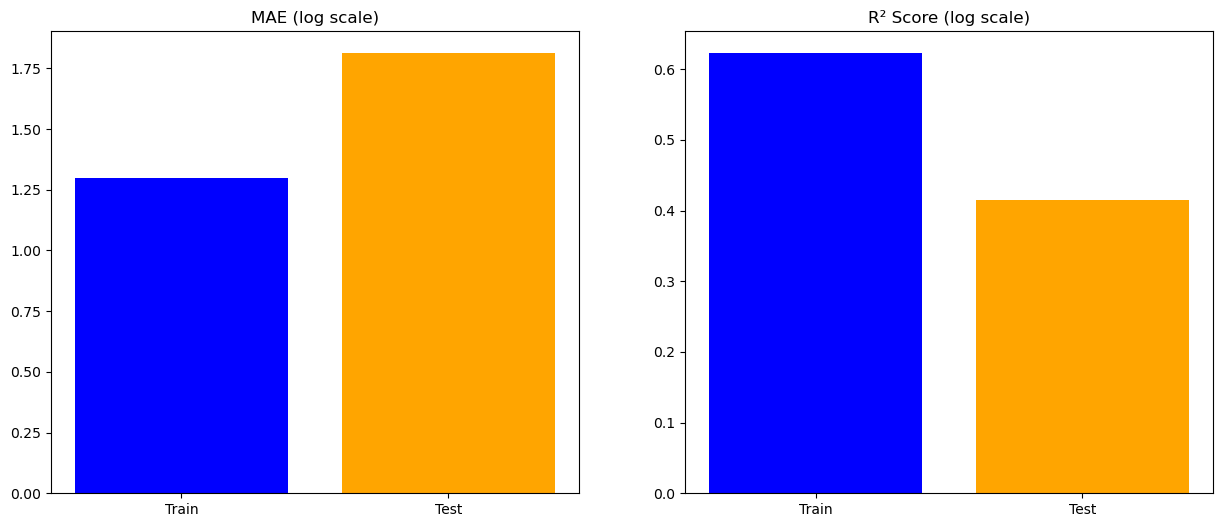

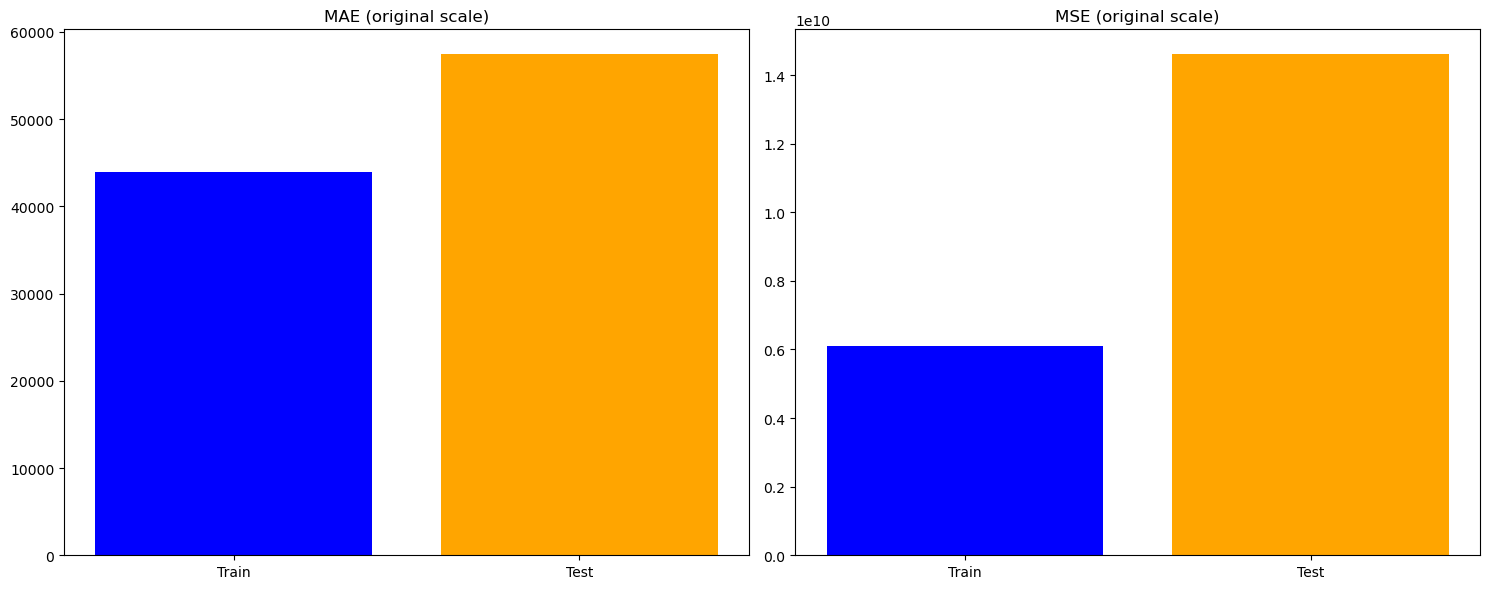

Metrics visualized and saved as linear_regression_metrics_comparison.png


<Figure size 640x480 with 0 Axes>

In [13]:
visualize_metrics(metrics, use_log)

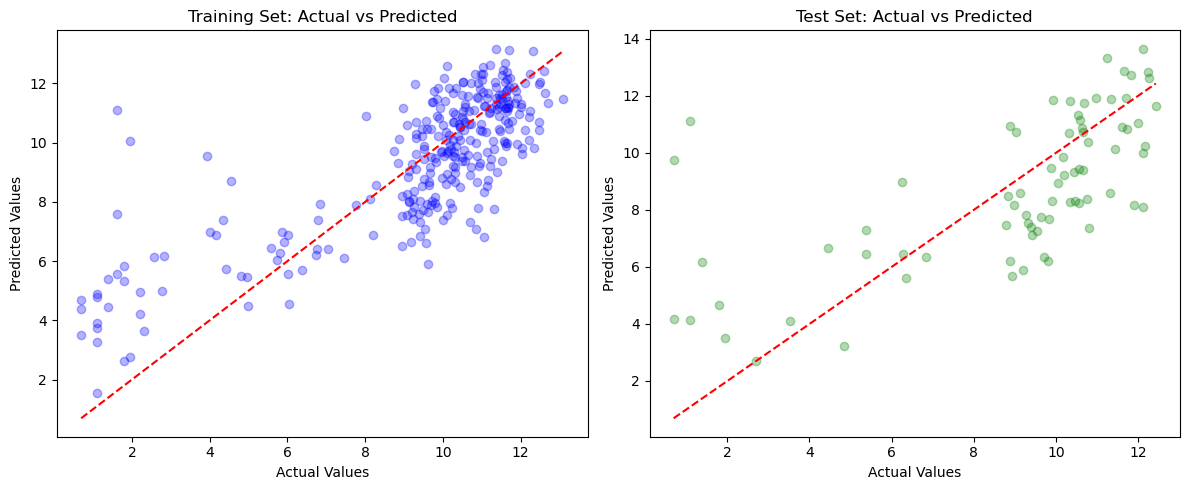

In [14]:
plt.figure(figsize=(12, 5))

# Training set plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.3, color='blue')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Set: Actual vs Predicted')

# Test set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.3, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Set: Actual vs Predicted')

plt.tight_layout()
plt.show()

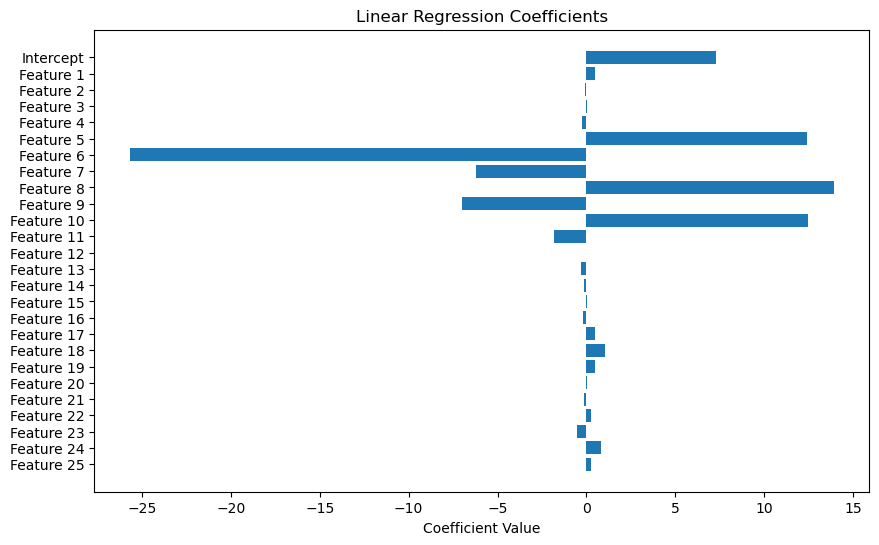

In [15]:
coefficients = lr_model.coef_
intercept = lr_model.intercept_

# If no feature names provided, create generic labels
feature_names = [f'Feature {i+1}' for i in range(len(coefficients))]

# Combine intercept and coefficients
all_coeffs = np.insert(coefficients, 0, intercept)
all_labels = ['Intercept'] + feature_names

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(all_labels, all_coeffs)
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.gca().invert_yaxis()  # Show highest coefficients at top
plt.show()

In [16]:
X_train.shape

(300, 25)

In [17]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression

In [18]:
class BikeVolumeNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(BikeVolumeNN, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.BatchNorm1d(64, momentum=0.9),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32, momentum=0.9),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),

            torch.nn.Linear(32, 16),
            torch.nn.BatchNorm1d(16, momentum=0.9),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),

            torch.nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

In [19]:
def prepare_data(file_path, use_log=True, select_features=25):
    """
    Modified data preparation for scikit-learn models
    Returns numpy arrays instead of DataLoaders
    """
    df = pd.read_csv(file_path)
    
    # Create log-transformed target if specified
    y = np.log1p(df['bike_volume']) if use_log else df['bike_volume']
    X = df.drop('bike_volume', axis=1)
    
    # Feature selection
    if select_features > 0:
        selector = SelectKBest(f_regression, k=select_features)
        X = selector.fit_transform(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, use_log

In [20]:
def load_nn_model(model_path, input_dim):
    """Load trained neural network"""
    model = BikeVolumeNN(input_dim)
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

In [21]:
data_path = 'merged_nyc_grid_data.csv'
nn_model_path = 'bike_volume_model_run5.pth'
use_log = True
select_features = 25

# Prepare data
X_train, X_test, y_train, y_test, use_log = prepare_data(
    data_path, use_log, select_features
)

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Load and evaluate Neural Network
nn_model = load_nn_model(nn_model_path, X_train.shape[1])
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    nn_pred = nn_model(X_test_tensor).numpy().flatten()

# Convert back to original scale if using log
if use_log:
    y_test_orig = np.expm1(y_test)
    lr_pred_orig = np.expm1(lr_pred)
    nn_pred_orig = np.expm1(nn_pred)

In [22]:
metrics = {
    'Linear Regression': {
        'log': {
            'R²': r2_score(y_test, lr_pred),
            'MAE': mean_absolute_error(y_test, lr_pred),
            'MSE': mean_squared_error(y_test, lr_pred)
        },
        'original': {
            'MAE': mean_absolute_error(y_test_orig, lr_pred_orig),
            'MSE': mean_squared_error(y_test_orig, lr_pred_orig)
        } if use_log else None
    },
    'Neural Network': {
        'log': {
            'R²': r2_score(y_test, nn_pred),
            'MAE': mean_absolute_error(y_test, nn_pred),
            'MSE': mean_squared_error(y_test, nn_pred)
        },
        'original': {
            'MAE': mean_absolute_error(y_test_orig, nn_pred_orig),
            'MSE': mean_squared_error(y_test_orig, nn_pred_orig)
        } if use_log else None
    }
}

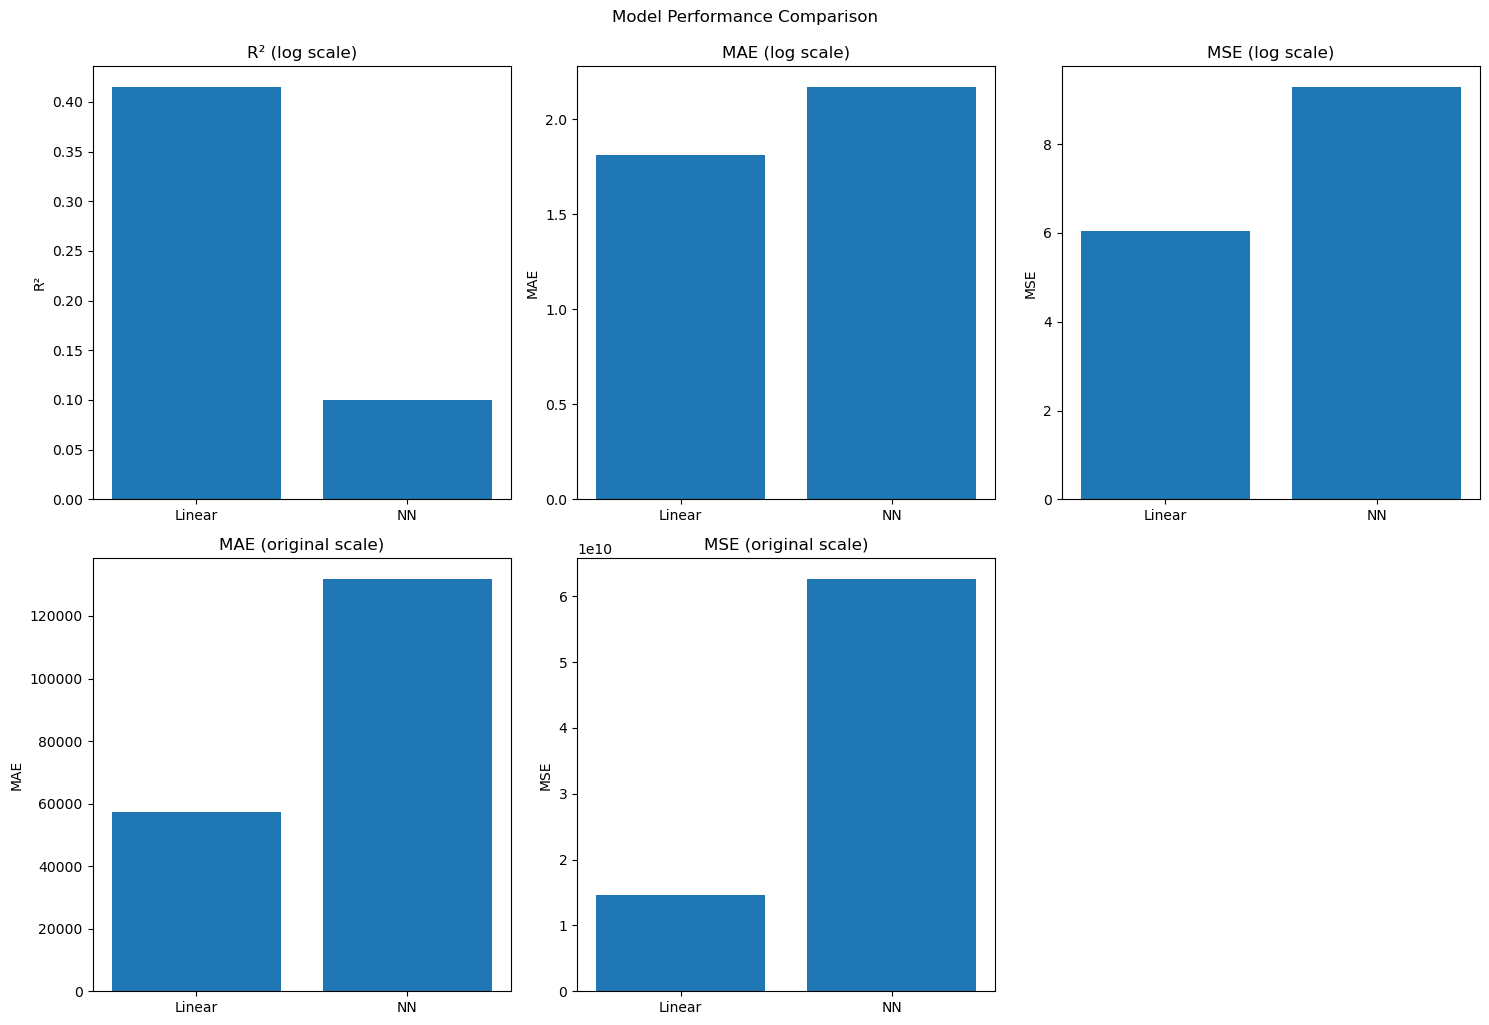

In [23]:
plt.figure(figsize=(15, 10))
    
# Metrics comparison
metrics_to_plot = ['R²', 'MAE', 'MSE']
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    plt.bar(['Linear', 'NN'], 
            [metrics['Linear Regression']['log'][metric], 
                metrics['Neural Network']['log'][metric]])
    plt.title(f'{metric} (log scale)')
    plt.ylabel(metric)

if use_log:
    orig_metrics = ['MAE', 'MSE']
    for i, metric in enumerate(orig_metrics, 4):
        plt.subplot(2, 3, i)
        plt.bar(['Linear', 'NN'], 
                [metrics['Linear Regression']['original'][metric], 
                metrics['Neural Network']['original'][metric]])
        plt.title(f'{metric} (original scale)')
        plt.ylabel(metric)

plt.tight_layout()
plt.suptitle('Model Performance Comparison', y=1.02)
plt.show()

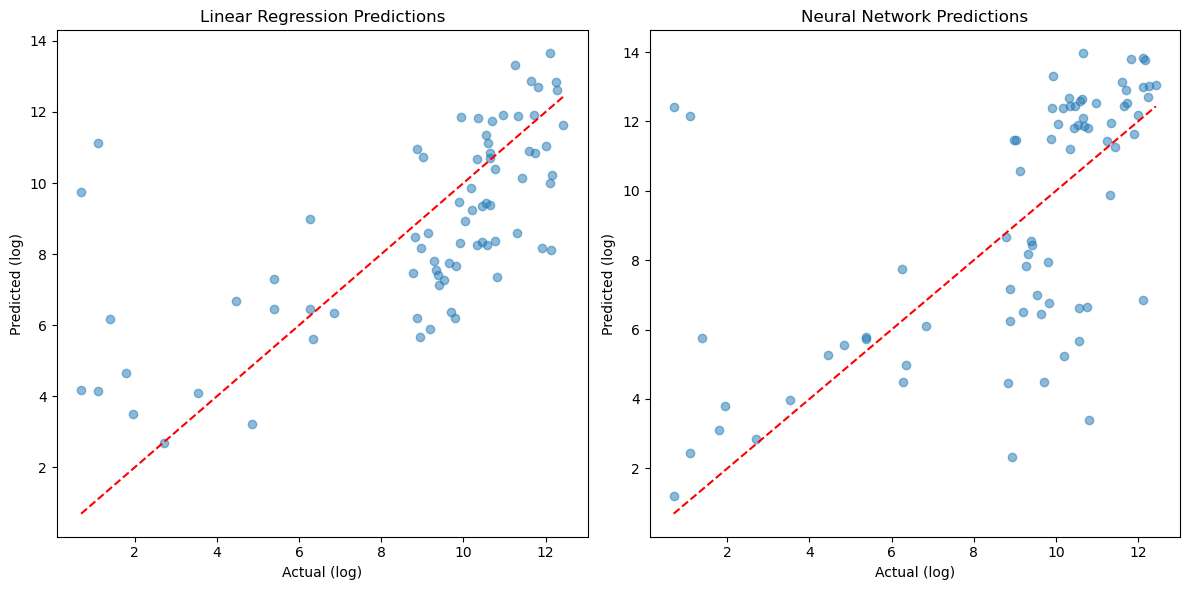

In [24]:
plt.figure(figsize=(12, 6))
    
plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual (log)')
plt.ylabel('Predicted (log)')
plt.title('Linear Regression Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, nn_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual (log)')
plt.ylabel('Predicted (log)')
plt.title('Neural Network Predictions')

plt.tight_layout()
plt.show()

In [25]:
print("Linear Regression Metrics:")
print(f"Log Scale - R²: {metrics['Linear Regression']['log']['R²']:.3f}, MAE: {metrics['Linear Regression']['log']['MAE']:.3f}, MSE: {metrics['Linear Regression']['log']['MSE']:.3f}")
if use_log:
    print(f"Original Scale - MAE: {metrics['Linear Regression']['original']['MAE']:.1f}, MSE: {metrics['Linear Regression']['original']['MSE']:.1f}")

print("\nNeural Network Metrics:")
print(f"Log Scale - R²: {metrics['Neural Network']['log']['R²']:.3f}, MAE: {metrics['Neural Network']['log']['MAE']:.3f}, MSE: {metrics['Neural Network']['log']['MSE']:.3f}")
if use_log:
    print(f"Original Scale - MAE: {metrics['Neural Network']['original']['MAE']:.1f}, MSE: {metrics['Neural Network']['original']['MSE']:.1f}")


Linear Regression Metrics:
Log Scale - R²: 0.415, MAE: 1.812, MSE: 6.037
Original Scale - MAE: 57415.5, MSE: 14601626645.4

Neural Network Metrics:
Log Scale - R²: 0.100, MAE: 2.169, MSE: 9.290
Original Scale - MAE: 131832.7, MSE: 62627919119.6
